### Summarize mean daily standing biomass by pasture at CPER
Uses pre-processed daily Biomass rasters from Harmonized Landsat Sentinel (HLS - see Kearney et al. 2022). Computes the mean of all grid cells within each pasture. Returns a .csv file with a single Biomass value for each date for each pasture.

In [1]:
import rioxarray as riox
import rasterio as rio
import xarray as xr
import os
import re
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from hlsstack.hls_funcs.masks import shp2mask
from tqdm import tqdm
import glob

In [9]:
# dask cluster location
cluster_loc = 'local'

# path to HLS biomass data
hls_path = '/mnt/c/Users/Sean.Kearney/git_repos/hls_nrt/data/gcloud/hls_cper_{}_gcloud.nc'

# the path to a shapefile with CPER pasture boundaries
cper_f = '../data/ground/boundaries/cper_pastures_2017_dissolved.shp'

# the range of years to be processed
yrs = range(2014, 2024)

# the output path for the csv file
out_f = '/mnt/t/3-GIS/CPER/Layers/CPER_RS_avgs/cper_pasture_hls_biomass_2014_2023.csv'

In [3]:
# whether to overwrite all existing complete years
overwrite_complete_yrs = False

# whether to overwrite incomplete years (or simply append new data)
overwrite_incomplete_yrs = True

In [4]:
# setup the dask cluster
if cluster_loc == 'local':
    #os.chdir(wkDIR)
    print('   setting up Local cluster...')
    from dask.distributed import LocalCluster, Client
    import dask
    cluster = LocalCluster(n_workers=8, threads_per_worker=2)
    client = Client(cluster)
    display(client)
    inDIR = 'data/'

   setting up Local cluster...


2023-09-11 14:04:44,440 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-uwa6xyph', purging
2023-09-11 14:04:44,441 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-tsrl4ni6', purging
2023-09-11 14:04:44,441 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-tae_alix', purging
2023-09-11 14:04:44,441 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-6sf77fsa', purging
2023-09-11 14:04:44,441 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-j5oawb4b', purging
2023-09-11 14:04:44,441 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-28jpjfdv', purging
2023-09-11 14:04:44,442 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-53hjsu45', purging

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 11.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44675,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 11.85 GiB
Comm: tcp://127.0.0.1:36583,Total threads: 2
Dashboard: http://127.0.0.1:41567/status,Memory: 1.48 GiB
Nanny: tcp://127.0.0.1:39413,


In [5]:
# prepare the pasture boundaries to be converted into an xarray mask
cper = gpd.read_file(cper_f).to_crs(32613)
cper_info = cper[['Pasture', 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
past_dict = {row.id+1: row.Pasture for _, row in cper_info.iterrows()}
past_dict[0] = 'UNK'
cper_mask_shp = [(row.geometry, row.id+1) for _, row in cper_info.iterrows()]

In [18]:
# load and preprare any existing output data
if os.path.exists(out_f):
    if not overwrite_complete_yrs:
        df_out = pd.read_csv(out_f, parse_dates=[0])
        if overwrite_incomplete_yrs:
            max_yday = df_out.groupby(df_out['Year'])['date'].max().dt.dayofyear
            drop_yrs = max_yday[max_yday < 365].index.values
            if len(drop_yrs) > 0:
                print('Dropping incomplete years:')
                print(drop_yrs)
                df_out = df_out[~df_out['Year'].isin(drop_yrs)].copy()
else:
    df_out = None

In [20]:
# loop through each year and extract pasture biomass means for each date
for idx, yr in enumerate(tqdm(yrs)):
    if yr in df_out['Year'].unique():
        continue
    else:
        # define the file path
        fpath = hls_path.format(str(yr))
        # read in data, selecting only NDVI
        ds = riox.open_rasterio(fpath, masked=True, variable='Biomass')
        # reproject if necessary
        if ds.rio.crs != cper.crs:
            ds = ds.rio.reproject(cper.crs)
        # create the pasture mask from shapefile
        cper_mask = shp2mask(shp=cper_mask_shp, 
                             transform=ds.rio.transform(), 
                             outshape=ds['Biomass'].shape[1:], 
                             xr_object=ds['Biomass'])
        # convert from numeric id's to pasture names
        past_mask = np.array([past_dict[i] for i in cper_mask.values.flatten()]).reshape(cper_mask.shape)
        # add the pasture mask to the biomass dataset
        ds = ds.assign(Pasture=(['y', 'x'], past_mask)).chunk({'y': 50, 'x': 50})
        ds = ds.set_coords('Pasture')
        # get pasture means and convert to dataframe
        df_yr = ds.groupby(
            ds['Pasture']).mean(
            dim='stacked_y_x').to_dataframe().reset_index().drop(
            columns='spatial_ref')
        df_yr['Year'] = yr
        df_yr = df_yr.rename(columns={'Biomass': 'Biomass_lbs_ac'})
        # add the data source to the output dataframe
        df_yr['Source'] = 'HLS'
        # create the initial output dataframe if it doesn't exist
        if df_out is None:
            df_out = df_yr.copy()
        # append to the existing output dataframe
        else:
            df_out = pd.concat([df_out, df_yr])

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.53it/s]


In [21]:
df_out

,date,Pasture,Biomass_lbs_ac,Year,Source
0,2014-01-01 00:00:00,10SNE,1412.072900,2014,HLS
1,2014-01-01 00:00:00,11NS,1131.853900,2014,HLS
2,2014-01-01 00:00:00,11NW,1046.856300,2014,HLS
3,2014-01-01 00:00:00,12C,1218.906600,2014,HLS
4,2014-01-01 00:00:00,12NE,1163.776200,2014,HLS
...,...,...,...,...,...
14017,2023-09-03 00:00:00,Saltflat,1800.341553,2023,HLS
14018,2023-09-03 00:00:00,Slayton,1547.255981,2023,HLS
14019,2023-09-03 00:00:00,Snowfence,1480.738037,2023,HLS
14020,2023-09-03 00:00:00,South,1153.053833,2023,HLS


In [22]:
# quality control check that all pastures are present for each year
df_out.groupby('Year').apply(lambda x: x['Pasture'].unique())

Year
2014    [10SNE, 11NS, 11NW, 12C, 12NE, 12NW, 13E, 13W,...
2015    [10SNE, 11NS, 11NW, 12C, 12NE, 12NW, 13E, 13W,...
2016    [10SNE, 11NS, 11NW, 12C, 12NE, 12NW, 13E, 13W,...
2017    [10SNE, 11NS, 11NW, 12C, 12NE, 12NW, 13E, 13W,...
2018    [10SNE, 11NS, 11NW, 12C, 12NE, 12NW, 13E, 13W,...
2019    [10SNE, 11NS, 11NW, 12C, 12NE, 12NW, 13E, 13W,...
2020    [10SNE, 11NS, 11NW, 12C, 12NE, 12NW, 13E, 13W,...
2021    [10SNE, 11NS, 11NW, 12C, 12NE, 12NW, 13E, 13W,...
2022    [10SNE, 11NS, 11NW, 12C, 12NE, 12NW, 13E, 13W,...
2023    [10SNE, 11NS, 11NW, 12C, 12NE, 12NW, 13E, 13W,...
dtype: object

In [23]:
# preview the output dataframe
df_out

,date,Pasture,Biomass_lbs_ac,Year,Source
0,2014-01-01 00:00:00,10SNE,1412.072900,2014,HLS
1,2014-01-01 00:00:00,11NS,1131.853900,2014,HLS
2,2014-01-01 00:00:00,11NW,1046.856300,2014,HLS
3,2014-01-01 00:00:00,12C,1218.906600,2014,HLS
4,2014-01-01 00:00:00,12NE,1163.776200,2014,HLS
...,...,...,...,...,...
14017,2023-09-03 00:00:00,Saltflat,1800.341553,2023,HLS
14018,2023-09-03 00:00:00,Slayton,1547.255981,2023,HLS
14019,2023-09-03 00:00:00,Snowfence,1480.738037,2023,HLS
14020,2023-09-03 00:00:00,South,1153.053833,2023,HLS


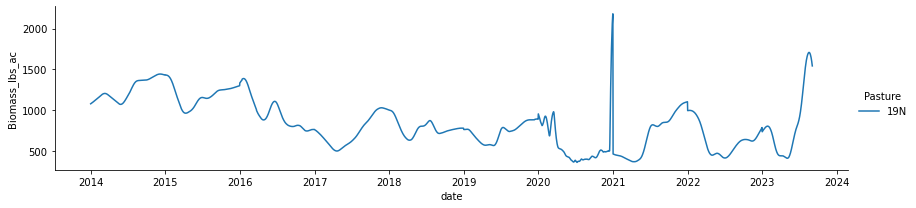

In [27]:
# plot all pastures and all dates on a single figure
sns.relplot(data=df_out[df_out['Pasture'] == '19N'], x='date', y='Biomass_lbs_ac', hue='Pasture', kind="line", errorbar=None,
            height=3, aspect=4)

In [28]:
# write the output dataframe to disk
df_out.to_csv(out_f, index=False)

Bad pipe message: %s [b'\x82Q\xd3\xec\x1ds\x87I\xc4`F\xc5A\x03\xc2\x87\x03M\x00\x01p\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00A\x00B\x00C\x00D\x00E\x00F\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5']
Bad pipe message: %s [b'e+N\xb2\xbbm\x03d\xa3\x88\xfb]H\xbf\xedU:J\x00\x01p\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00', b'\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007']
Bad pipe message: %s [b'\x9c\xfc\xe6\x9e`o\xc0\xaefl_q\xec]\xc6K\xee3\x00\

#### Plot saved results

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
# read in the saved .csv output
df_saved = pd.read_csv(out_f, parse_dates=[0])
#df_saved

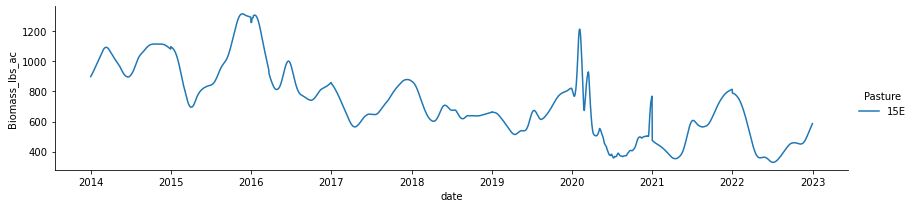

In [17]:
# plot all pastures and all dates on a single figure
sns.relplot(data=df_saved[df_saved['Pasture'] == '15E'], x='date', y='Biomass_lbs_ac', hue='Pasture', kind="line", errorbar=None,
            height=3, aspect=4)